#Bài 3


#Load pretrained model

In [20]:
with open('W2V_150.txt') as f:
    lines = f.readlines()
    
lines=lines[2:]

In [21]:
import  io
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
import torch

vocab={}
for line in lines:
    s=line.split()
    vocab[s[0]]= np.array(s[1:], dtype="float")

#Create training dataset

In [22]:
with open('Synonym_vietnamese.txt') as f:
    lines = f.readlines()

synonym = []
for i in lines:
    pair = i.split()
    if len(pair)<2:
        break
    if (pair[0] in vocab) and (pair[1] in vocab):
        synonym.append([vocab[pair[0]], vocab[pair[1]]])

synonym = torch.tensor(np.array(synonym), dtype=torch.float)

In [23]:
with open('Antonym_vietnamese.txt') as f:
    lines = f.readlines()

antonym = []
for i in lines:
    pair = i.split()
    if len(pair)<2:
        break
    if (pair[0] in vocab) and (pair[1] in vocab):
        antonym.append([vocab[pair[0]], vocab[pair[1]]])

antonym = torch.tensor(np.array(antonym), dtype=torch.float)

In [24]:
x_train = torch.cat((synonym, antonym), 0).to("cuda")

In [25]:
y_train = torch.cat((torch.ones(302), torch.zeros(1731)), 0).to("cuda")

#Create validation dataset

In [31]:
with open('600_adj_pairs.txt') as f:
    lines = f.readlines()

val_x = []
val_y = []
for line in lines:
    pair = line.split()
    if len(pair)<2:
        break
    if (pair[0] in vocab) and (pair[1] in vocab):
        val_x.append([vocab[pair[0]], vocab[pair[1]]])
        if pair[2]== "SYN":
            val_y.append(1)
        if pair[2]=="ANT":
            val_y.append(0)

val_x = torch.tensor(val_x, dtype=torch.float, device="cuda")
val_y = torch.tensor(val_y, dtype=torch.float, device="cuda")

#Create model and declare hyperparameters

In [26]:
INPUT_DIM = 300
BATCH_SIZE = 32
OUTPUT_DIM=1
LR=0.001
EPOCHS = 100

In [27]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [32]:
val_dataset = TensorDataset(val_x, val_y)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [28]:
from torch import nn 
import torch
import matplotlib.pyplot as plt

class MLP(nn.Module):
  def __init__(self, in_feature, out_feature):
    super().__init__()
    self.fc1 = nn.Linear(in_feature, 10, bias=False)
    self.relu1 = nn.ReLU()
    self.fc2 = nn.Linear(10, out_feature, bias=False)
    self.sig = nn.Sigmoid()
  
  def forward(self, x):
    out = self.fc1(x)
    out = self.relu1(out)
    out = self.fc2(out)
    out = self.sig(out)
    return out

In [71]:
model = MLP(INPUT_DIM, OUTPUT_DIM).cuda().float()

In [72]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Training and validation

In [73]:
from tqdm import tqdm

losses = []
val_losses = []
val_accs = []
val_f1s = []
val_precisions = []
val_recalls = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for i, (input, target) in enumerate(train_loader):
        optimizer.zero_grad() 
        output = model(torch.reshape(input, (-1,300)))
        loss = criterion(torch.squeeze(output), target) 
        loss.backward()
        total_loss+=loss.item()
        optimizer.step()
    losses.append(total_loss/(i+1))

    model.eval()

    total_val_loss = 0

    with torch.no_grad():
        correct = 0
        total = 0
        total_output = []
        total_target = []
        for _, (val_input, val_target) in enumerate(val_loader):
            val_output = model(torch.reshape(val_input, (-1,300)))
            predict = torch.round(val_output)
            val_loss = criterion(torch.squeeze(val_output), val_target)
            
            total_val_loss += val_loss.item()
            total += val_target.size(0)
            correct += (torch.squeeze(predict) == val_target).long().sum().item()
            total_output.append(torch.squeeze(predict).cpu())
            total_target.append(val_target.cpu())


        total_output = np.concatenate(total_output)
        total_target = np.concatenate(total_target)
        precision, recall, f1, _ = precision_recall_fscore_support(total_target, total_output, average=None, labels=[1.,0.])
    print("Epoch {} - val_accuracy: {} - val_loss : {:.4f}".format(
            epoch+1,
            correct / total,
            total_val_loss / (len(val_loader))))
    val_losses.append(total_val_loss / (len(val_loader)))
    val_accs.append(correct / total)
    val_f1s.append(f1)
    val_precisions.append(precision)
    val_recalls.append(recall)
    

Epoch 1 - val_accuracy: 0.5599214145383105 - val_loss : 0.9382
Epoch 2 - val_accuracy: 0.5697445972495089 - val_loss : 1.0021
Epoch 3 - val_accuracy: 0.5893909626719057 - val_loss : 0.9913
Epoch 4 - val_accuracy: 0.618860510805501 - val_loss : 0.9793
Epoch 5 - val_accuracy: 0.6247544204322201 - val_loss : 1.0291
Epoch 6 - val_accuracy: 0.6444007858546169 - val_loss : 1.0010
Epoch 7 - val_accuracy: 0.6542239685658153 - val_loss : 1.0114
Epoch 8 - val_accuracy: 0.6620825147347741 - val_loss : 1.0331
Epoch 9 - val_accuracy: 0.6758349705304518 - val_loss : 1.0029
Epoch 10 - val_accuracy: 0.6777996070726916 - val_loss : 1.0612
Epoch 11 - val_accuracy: 0.68762278978389 - val_loss : 1.0299
Epoch 12 - val_accuracy: 0.6915520628683693 - val_loss : 1.0755
Epoch 13 - val_accuracy: 0.693516699410609 - val_loss : 1.1112
Epoch 14 - val_accuracy: 0.7013752455795678 - val_loss : 1.0968
Epoch 15 - val_accuracy: 0.6915520628683693 - val_loss : 1.1998
Epoch 16 - val_accuracy: 0.6954813359528488 - val_los

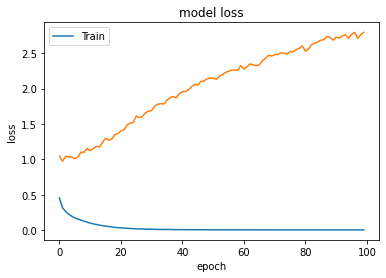

In [56]:
import matplotlib.pyplot as plt


plt.plot(losses)
plt.plot(val_losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

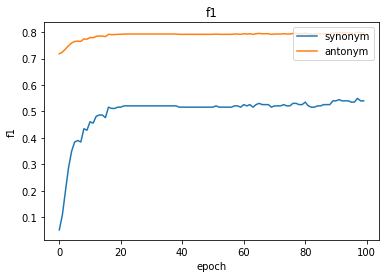

In [58]:
plt.plot(val_f1s)
plt.title('f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['synonym',"antonym"], loc='upper right')
plt.show()

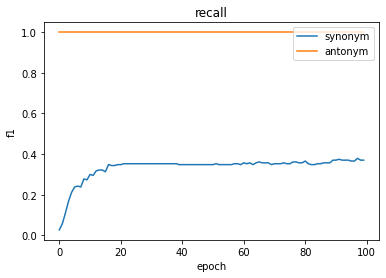

In [60]:
plt.plot(val_recalls)
plt.title('recall')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['synonym',"antonym"], loc='upper right')
plt.show()

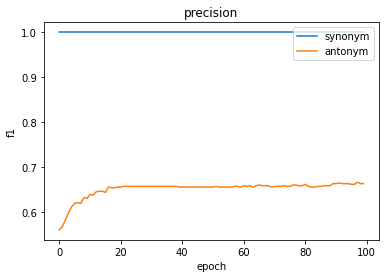

In [62]:
plt.plot(val_precisions)
plt.title('precision')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['synonym',"antonym"], loc='upper right')
plt.show()